In [56]:
""" CIND820 Project  
Sales forecasting using various methods just as XGboost and SARIMA
Dataset from - https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II
"""
import pandas as pd
import numpy as np
import os
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import xgboost 
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [195]:

#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"
df = pd.concat(pd.read_excel(url, sheet_name=None), ignore_index=True)


In [3]:
# pathDir = os.getcwd()
# fileName = "Online Retail.xlsx"
# pathFile = "{}{}{}".format(pathDir,os.sep,fileName)
# pathFile
# df = pd.read_excel(pathFile)

In [189]:
#Use this to look at the items with the highest counts to use in our data
df['Description'].value_counts()


WHITE HANGING HEART T-LIGHT HOLDER    304
JUMBO BAG RED RETROSPOT               302
REGENCY CAKESTAND 3 TIER              301
ASSORTED COLOUR BIRD ORNAMENT         300
LUNCH BAG RED RETROSPOT               299
                                     ... 
ETCHED GLASS STAR TREE DECORATION       1
BLUE/YELLOW CERAMIC CANDLE HOLDER       1
*Boombox Ipod Classic                   1
ANT SILVER TURQUOISE BOUDICCA RING      1
???lost                                 1
Name: Description, Length: 4223, dtype: int64

In [5]:
# profile = ProfileReport(df)
# profile.to_widgets()

In [188]:
df.describe(include=object)

,Description
count,278930
unique,4223
top,WHITE HANGING HEART T-LIGHT HOLDER
freq,304


In [196]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [197]:
#Select items to use in dataset, will use the 5 items with the most units purchased
filterItems = ["JUMBO BAG RED RETROSPOT","LUNCH BAG RED RETROSPOT","PARTY BUNTING","REGENCY CAKESTAND 3 TIER", "WHITE HANGING HEART T-LIGHT HOLDER"]
df = df[df["Description"].isin(filterItems)]
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
102,489442,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2009-12-01 09:46:00,2.95,13635.0,United Kingdom
147,489446,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2009-12-01 10:06:00,2.55,13758.0,United Kingdom
271,489465,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2009-12-01 10:52:00,2.55,13767.0,United Kingdom
366,489517,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1,2009-12-01 11:34:00,2.95,16329.0,United Kingdom
403,489519,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2009-12-01 11:37:00,2.55,17700.0,United Kingdom
...,...,...,...,...,...,...,...,...
1066751,581497,22423,REGENCY CAKESTAND 3 TIER,8,2011-12-09 10:23:00,24.96,NaN,United Kingdom
1066779,581497,47566,PARTY BUNTING,5,2011-12-09 10:23:00,10.79,NaN,United Kingdom
1066997,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
1067157,581538,20725,LUNCH BAG RED RETROSPOT,1,2011-12-09 11:34:00,1.65,14446.0,United Kingdom


In [198]:
#This sums all the quantities of a particular item that was purchased in a day
df2 = df.groupby(['Description', pd.Grouper(key='InvoiceDate', freq='D',label='left')])['Quantity'].sum().reset_index()
df2


,Description,InvoiceDate,Quantity
0,JUMBO BAG RED RETROSPOT,2010-05-14,2
1,JUMBO BAG RED RETROSPOT,2010-05-16,120
2,JUMBO BAG RED RETROSPOT,2010-05-17,0
3,JUMBO BAG RED RETROSPOT,2010-05-18,309
4,JUMBO BAG RED RETROSPOT,2010-05-19,3
...,...,...,...
2477,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-04,8
2478,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-05,313
2479,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-06,38
2480,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-07,202


In [199]:
#Changing items to its own column using unstack
#Using method found in https://stackoverflow.com/questions/26255671/pandas-column-values-to-columns
#df3 = df2.groupby(["InvoiceDate","Description"])["Quantity"].aggregate("first").unstack().fillna(0)
#df3

#Changing items to its own column using pivot
#Filling the NA values with 0 since they occur because there are no sales on that day for that particular item
df3 = df2.pivot(index="InvoiceDate", columns = "Description", values="Quantity").fillna(0)
df3

Description,JUMBO BAG RED RETROSPOT,LUNCH BAG RED RETROSPOT,PARTY BUNTING,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER
InvoiceDate,,,,,
2009-12-01,0.0,0.0,6.0,0.0,260.0
2009-12-02,0.0,0.0,9.0,0.0,750.0
2009-12-03,0.0,0.0,0.0,0.0,359.0
2009-12-04,0.0,0.0,15.0,0.0,178.0
2009-12-05,0.0,0.0,0.0,0.0,96.0
...,...,...,...,...,...
2011-12-05,66.0,50.0,16.0,36.0,313.0
2011-12-06,175.0,85.0,21.0,160.0,38.0
2011-12-07,85.0,35.0,3.0,130.0,202.0


In [200]:
#This fills in the days where there were no sales for any product
dateRange = pd.date_range(min(df3.index),max(df3.index))
df4 = df3.reindex(dateRange,fill_value=0)
df4

Description,JUMBO BAG RED RETROSPOT,LUNCH BAG RED RETROSPOT,PARTY BUNTING,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER
2009-12-01,0.0,0.0,6.0,0.0,260.0
2009-12-02,0.0,0.0,9.0,0.0,750.0
2009-12-03,0.0,0.0,0.0,0.0,359.0
2009-12-04,0.0,0.0,15.0,0.0,178.0
2009-12-05,0.0,0.0,0.0,0.0,96.0
...,...,...,...,...,...
2011-12-05,66.0,50.0,16.0,36.0,313.0
2011-12-06,175.0,85.0,21.0,160.0,38.0
2011-12-07,85.0,35.0,3.0,130.0,202.0
2011-12-08,96.0,52.0,22.0,25.0,58.0


In [132]:
# profile = ProfileReport(df4)
# profile.to_widgets()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

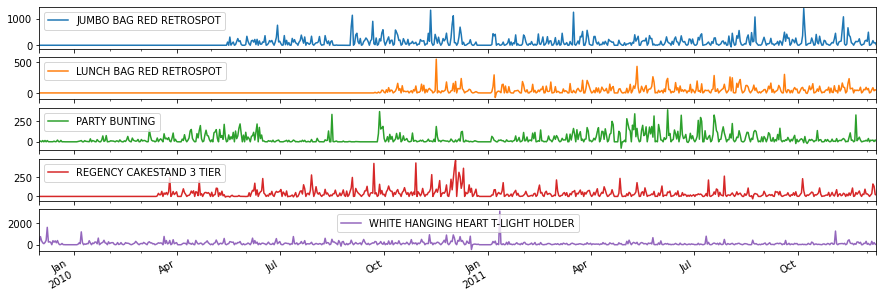

In [201]:
#Plot of the sales of items 
df4.plot(subplots=True, figsize=(15,5))

Text(0.5, 1.0, 'Residuals')

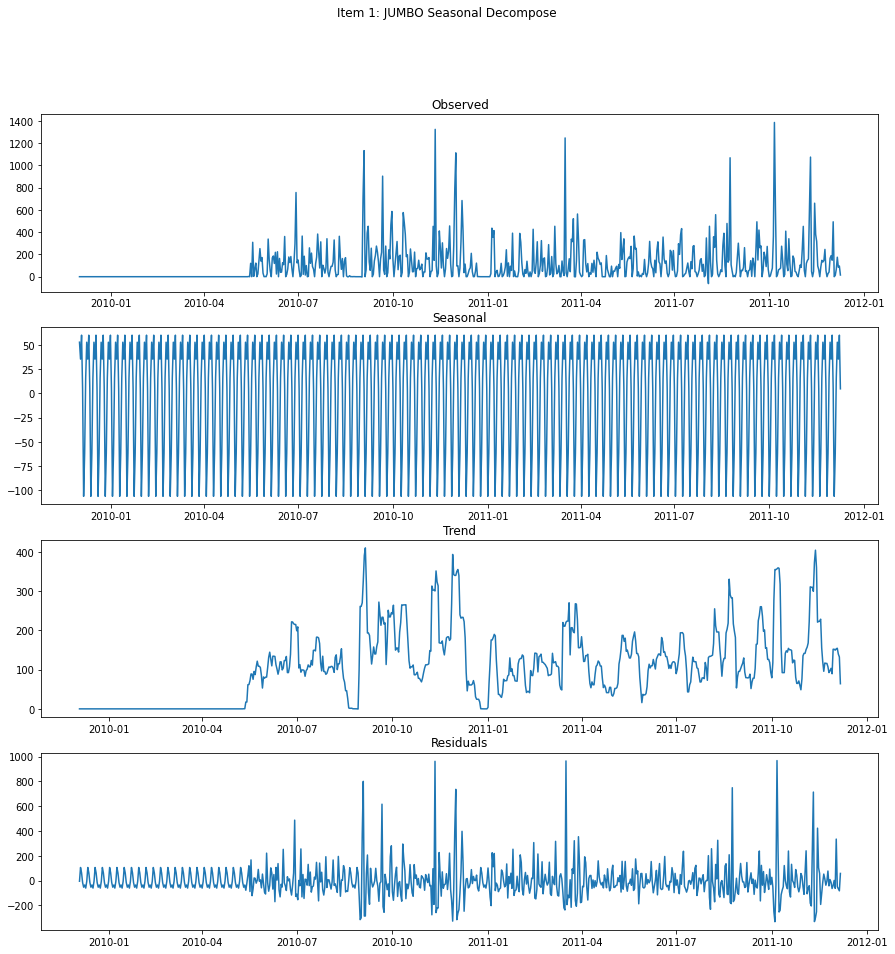

In [202]:
#We can use the seasonal_decompose function from the statsmodel package
#This uses a naive decomposition method where it will assume the model is
#y = level + trend + seasonality + noise
#and it will seperate the trend seasonality and noise for us
decomp1=seasonal_decompose(df4.iloc[:,0],model='additive')
fig, (ax1,ax2,ax3,ax4)= plt.subplots(4,figsize=(15,15))
fig.suptitle('Item 1: JUMBO Seasonal Decompose')
ax1.plot(decomp1.observed)
ax1.set_title("Observed")
ax2.plot(decomp1.seasonal)
ax2.set_title("Seasonal")
ax3.plot(decomp1.trend)
ax3.set_title("Trend")
ax4.plot(decomp1.resid)
ax4.set_title("Residuals")

Text(0.5, 1.0, 'Residuals')

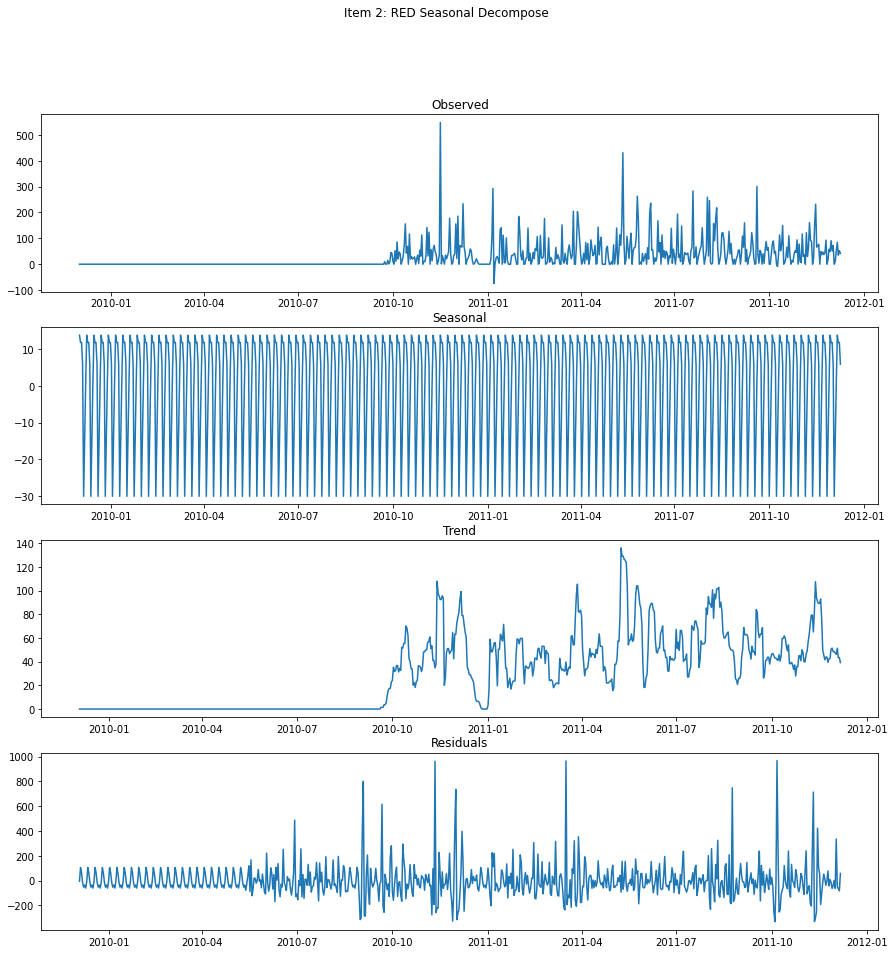

In [146]:
decomp2=seasonal_decompose(df4.iloc[:,1],model='additive')
fig, (ax1,ax2,ax3,ax4)= plt.subplots(4,figsize=(15,15))
fig.suptitle('Item 2: LUNCH Seasonal Decompose')
ax1.plot(decomp2.observed)
ax1.set_title("Observed")
ax2.plot(decomp2.seasonal)
ax2.set_title("Seasonal")
ax3.plot(decomp2.trend)
ax3.set_title("Trend")
ax4.plot(decomp1.resid)
ax4.set_title("Residuals")

Text(0.5, 1.0, 'Residuals')

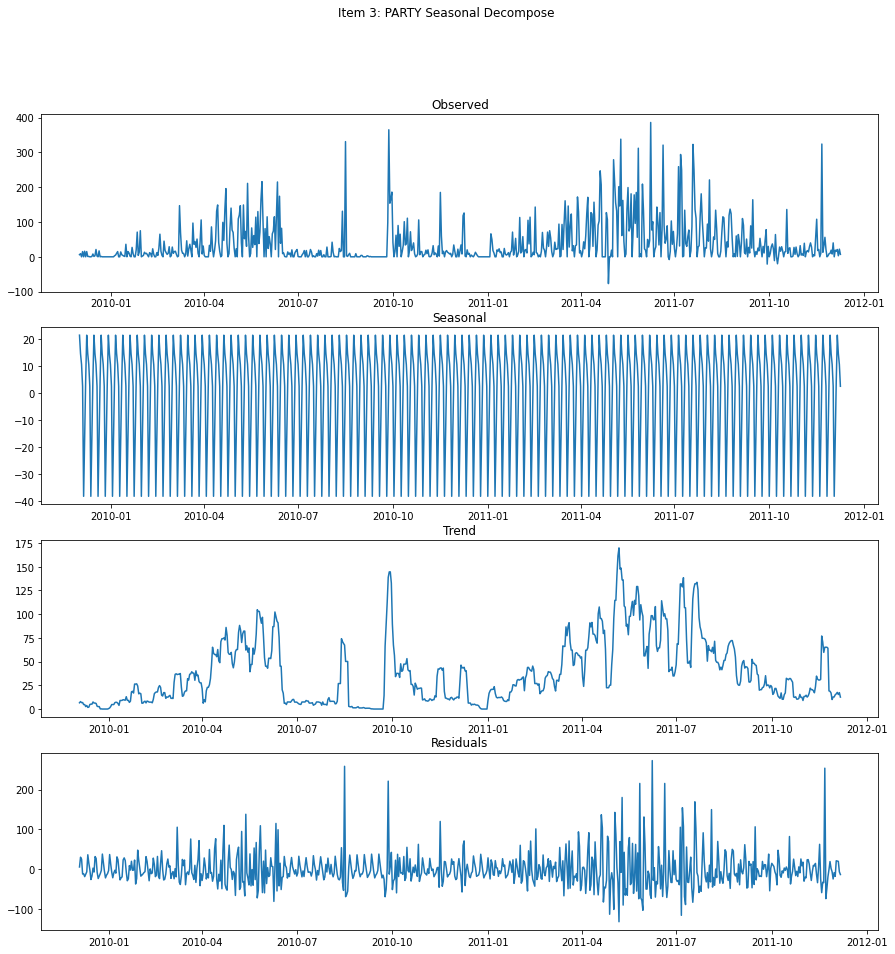

In [147]:
decomp3=seasonal_decompose(df4.iloc[:,2],model='additive')
fig, (ax1,ax2,ax3,ax4)= plt.subplots(4,figsize=(15,15))
fig.suptitle('Item 3: PARTY Seasonal Decompose')
ax1.plot(decomp3.observed)
ax1.set_title("Observed")
ax2.plot(decomp3.seasonal)
ax2.set_title("Seasonal")
ax3.plot(decomp3.trend)
ax3.set_title("Trend")
ax4.plot(decomp3.resid)
ax4.set_title("Residuals")

Text(0.5, 1.0, 'Residuals')

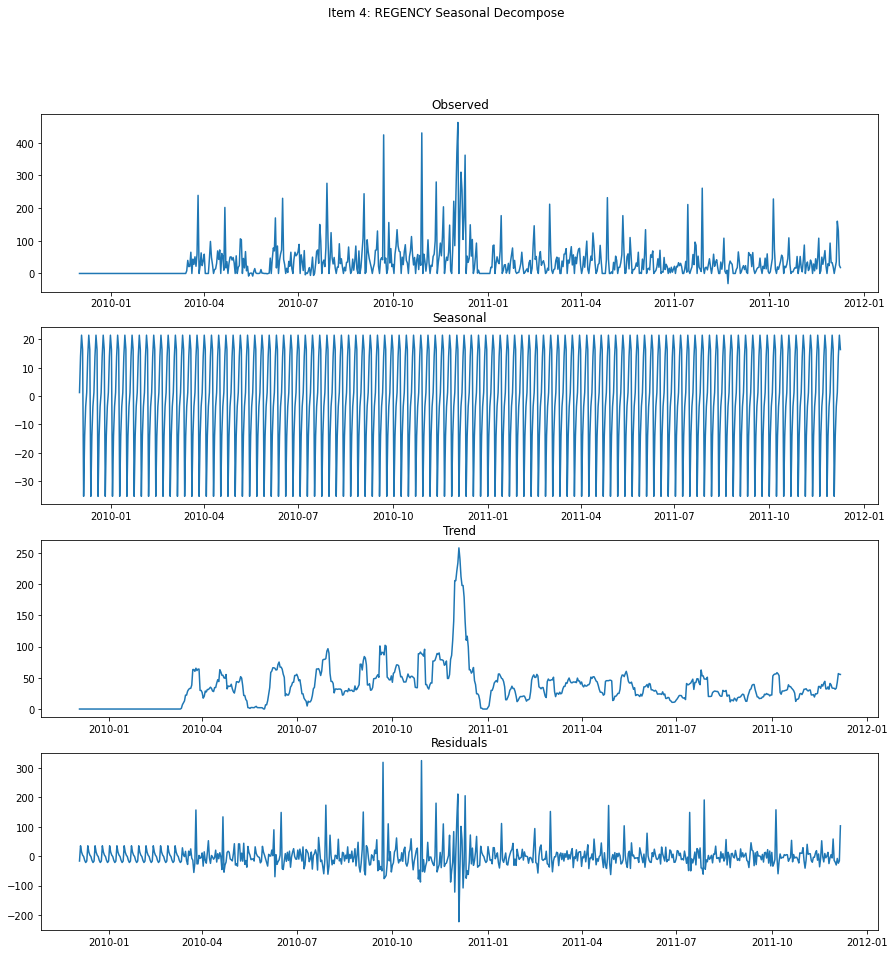

In [148]:
decomp4=seasonal_decompose(df4.iloc[:,3],model='additive')
fig, (ax1,ax2,ax3,ax4)= plt.subplots(4,figsize=(15,15))
fig.suptitle('Item 4: REGENCY Seasonal Decompose')
ax1.plot(decomp4.observed)
ax1.set_title("Observed")
ax2.plot(decomp4.seasonal)
ax2.set_title("Seasonal")
ax3.plot(decomp4.trend)
ax3.set_title("Trend")
ax4.plot(decomp4.resid)
ax4.set_title("Residuals")

Text(0.5, 1.0, 'Residuals')

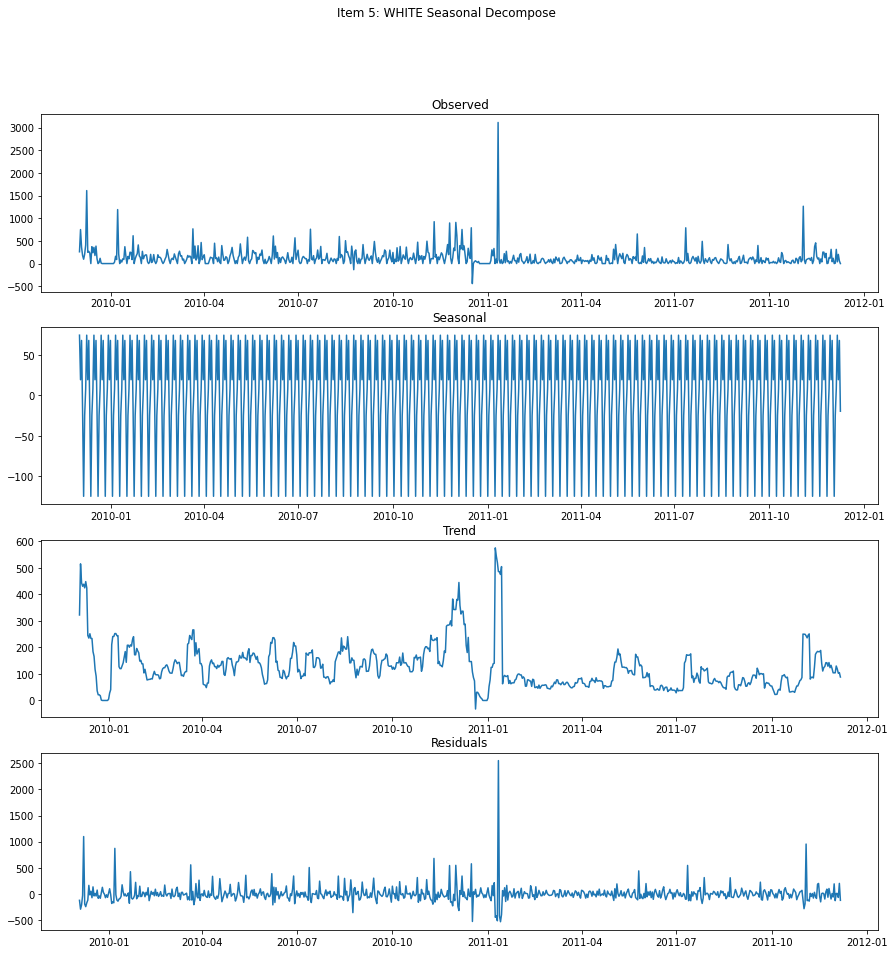

In [149]:
decomp5=seasonal_decompose(df4.iloc[:,4],model='additive')
fig, (ax1,ax2,ax3,ax4)= plt.subplots(4,figsize=(15,15))
fig.suptitle('Item 5: WHITE Seasonal Decompose')
ax1.plot(decomp5.observed)
ax1.set_title("Observed")
ax2.plot(decomp5.seasonal)
ax2.set_title("Seasonal")
ax3.plot(decomp5.trend)
ax3.set_title("Trend")
ax4.plot(decomp5.resid)
ax4.set_title("Residuals")

In [203]:
#We used ADF test to see if the data is stationary
# In our case we can use p= 0.05 as a cutoff
#If p is greater than 0.05 then it is not stationary
from statsmodels.tsa.stattools import adfuller
from numpy import log
adfuller1 = adfuller(df4.iloc[:,0])
adfuller2 = adfuller(df4.iloc[:,1])
adfuller3 = adfuller(df4.iloc[:,2])
adfuller4 = adfuller(df4.iloc[:,3])
adfuller5 = adfuller(df4.iloc[:,4])

for item in range(5):
    print("\n",filterItems[item])
    result= adfuller(df4.iloc[:,item])
    print("ADF Statistic: ",result[0])
    print("p=value: ",result[1])
    for key, value in result[4].items():
        print(key," : ",value)
    


 JUMBO BAG RED RETROSPOT
ADF Statistic:  -3.582764365533264
p=value:  0.006099215222848656
1%  :  -3.439477677285233
5%  :  -2.865568186630048
10%  :  -2.5689150720653977

 LUNCH BAG RED RETROSPOT
ADF Statistic:  -2.661750084392472
p=value:  0.08089424739759998
1%  :  -3.4394144152232995
5%  :  -2.8655403100177566
10%  :  -2.5689002207655443

 PARTY BUNTING
ADF Statistic:  -2.584802479760175
p=value:  0.09617914262088229
1%  :  -3.439490435810785
5%  :  -2.8655738086413374
10%  :  -2.568918067209286

 REGENCY CAKESTAND 3 TIER
ADF Statistic:  -3.589549705580556
p=value:  0.00596398668869175
1%  :  -3.439490435810785
5%  :  -2.8655738086413374
10%  :  -2.568918067209286

 WHITE HANGING HEART T-LIGHT HOLDER
ADF Statistic:  -7.577549163033771
p=value:  2.7361126798661202e-11
1%  :  -3.4393273074073045
5%  :  -2.8655019247555154
10%  :  -2.568879771109793


In [204]:
#Since the second and third item are not stationary we can log transform our data
dflog=df4.copy()

In [205]:
dflog=np.log(df4)
dflog.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
dflog = dflog.fillna(0)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [211]:
df4.describe()

Description,JUMBO BAG RED RETROSPOT,LUNCH BAG RED RETROSPOT,PARTY BUNTING,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER
count,739.000000,739.000000,739.000000,739.000000,739.000000
mean,105.669824,30.044655,38.037889,35.353180,125.913396
std,173.857164,54.726241,60.187117,55.081103,194.819291
min,-62.000000,-75.000000,-77.000000,-31.000000,-442.000000
25%,0.000000,0.000000,0.000000,0.000000,23.000000
50%,40.000000,0.000000,14.000000,19.000000,87.000000
75%,147.000000,41.000000,45.000000,49.000000,157.000000
max,1385.000000,548.000000,386.000000,462.000000,3113.000000


In [207]:
#Creates a training and test split with 70% training and 30% test. 
trainSize= 0.7

#Depending on if we are using untransformed or log transformed data we can uncomment a different line

#Using untransformed data
#train, test =train_test_split(df4, train_size= trainSize, shuffle= False)

#Using log transformed data
train, test =train_test_split(dflog, train_size= trainSize, shuffle= False)

In [208]:
#Create variables for training test start and end dates 
forecastStart=test.index.min()
forecastEnd=test.index.max()

In [20]:
arimaModel1 = ARIMA(train.iloc[:,0],order= (10,2,6)).fit()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization fail

In [209]:
def arimaModelTuning(train, test, pValues, dValues, qValues):
    bestScore = 999999999;
    for p in pValues:
        for d in dValues:
            for q in qValues:
                modelOrder = (p, d, q)
                try:
                    modelTune = ARIMA(train,order=(p, d, q))
                    modelTune = modelTune.fit()
                    modelForecast=modelTune.predict(start=forecastStart,end=forecastEnd, dynamic= True)
                    modelScore= metrics.mean_squared_error(test,modelForecast)
                    if modelScore < bestScore:
                        bestScore = modelScore
                        bestOrder = modelOrder
                    print("Order: ",modelOrder,"Score: ",modelScore)
                except: 
                    continue
    print("Best ARIMA order: ",bestOrder)
    print("Best order's score: ",bestScore)
                    
                
                
    
    

In [22]:
#Best item 1 order (5,0,6)
#Best item 2 order (5,0,5)
#Best item 3 order (5,0,9)
#Best item 4 order (9,0,6)
#Best item 5 order (6,0,9)
# arimaModelTuning(train.iloc[:,2], test.iloc[:,2],range(10),range(1),range(10))

In [210]:
#Creates the ARIMA models for the 5 items
arimaModel1 = ARIMA(train.iloc[:,0],order= (5,0,6)).fit()
arimaModel2 = ARIMA(train.iloc[:,1],order= (5,0,5)).fit()
arimaModel3 = ARIMA(train.iloc[:,2],order= (5,0,9)).fit()
arimaModel4 = ARIMA(train.iloc[:,3],order= (9,0,6)).fit()
arimaModel5 = ARIMA(train.iloc[:,4],order= (6,0,9)).fit()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization fail

In [24]:
arimaModel1.summary()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
D:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
D:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
D:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARMA Model Results                                
===================================================================================
Dep. Variable:     JUMBO BAG RED RETROSPOT   No. Observations:                  517
Model:                          ARMA(5, 6)   Log Likelihood                -942.763
Method:                            css-mle   S.D. of innovations                nan
Date:                     Sat, 24 Jul 2021   AIC                           1911.527
Time:                             15:57:51   BIC                           1966.751
Sample:                         12-01-2009   HQIC                          1933.166
                              - 05-01-2011                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             2.7239        nan        nan        nan         nan         nan
ar.L1.JUMBO BAG RED RETROSPOT     1.7997        nan        nan        nan         nan         nan
ar.L2.JUMBO BAG RED RETROSPOT    -2.2430      0.001  -2077.689      0.000      -2.245      -2.241
ar.L3.JUMBO BAG RED RETROSPOT     2.2424      0.001   2074.884      0.000       2.240       2.245
ar.L4.JUMBO BAG RED RETROSPOT    -1.7985    3.3e-05  -5.45e+04      0.000      -1.799      -1.798
ar.L5.JUMBO BAG RED RETROSPOT     0.9994    1.1e-05   9.06e+04      0.000       0.999       0.999
ma.L1.JUMBO BAG RED RETROSPOT    -1.5776      0.041    -38.866      0.000      -1.657      -1.498
ma.L2.JUMBO BAG RED RETROSPOT     2.0390      0.068     30.076      0.000       1.906       2.172
ma.L3.JUMBO BAG RED RETROSPOT    -1.8919      0.084    -22.421      0.000      -2.057      -1.727
ma.L4.JUMBO BAG RED RETROSPOT     1.5901      0.085     18.793      0.000       1.424       1.756
ma.L5.JUMBO BAG RED RETROSPOT    -0.7809      0.066    -11.826      0.000      -0.910      -0.651
ma.L6.JUMBO BAG RED RETROSPOT     0.0520      0.042      1.225      0.221      -0.031       0.135
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2233           -0.9750j            1.0003           -0.2858
AR.2           -0.2233           +0.9750j            1.0003            0.2858
AR.3            1.0000           -0.0000j            1.0000           -0.0000
AR.4            0.6230           -0.7822j            1.0000           -0.1429
AR.5            0.6230           +0.7822j            1.0000            0.1429
MA.1           -0.2339           -0.9927j            1.0199           -0.2868
MA.2           -0.2339           +0.9927j            1.0199            0.2868
MA.3            0.6428           -0.8032j            1.0287           -0.1426
MA.4            0.6428           +0.8032j            1.0287            0.1426
MA.5            1.3612           -0.0000j            1.3612           -0.0000
MA.6           12.8235           -0.0000j           12.8235           -0.0000
-----------------------------------------------------------------------------
"""

In [25]:
#ARIMA forecasts dynamic = true makes it so it uses previous forecasts to predict the forecasts after
arimaModel1Forecast= arimaModel1.predict(start=forecastStart,end=forecastEnd, dynamic= True)
arimaModel2Forecast= arimaModel2.predict(start=forecastStart,end=forecastEnd, dynamic= True)
arimaModel3Forecast= arimaModel3.predict(start=forecastStart,end=forecastEnd, dynamic= True)
arimaModel4Forecast= arimaModel4.predict(start=forecastStart,end=forecastEnd, dynamic= True)
arimaModel5Forecast= arimaModel5.predict(start=forecastStart,end=forecastEnd, dynamic= True)

In [26]:
#Creates a copy of the test dataframe we are going to add predictions to
testForecasts= test.copy()

In [27]:
#Adds an ARIMA forecast column to the testForecast dataframe we made
testForecasts["ARIMA Forecast 1 Jumbo"]=np.exp(arimaModel1Forecast)
testForecasts["ARIMA Forecast 2 Lunch"]=np.exp(arimaModel2Forecast)
testForecasts["ARIMA Forecast 3 Party"]=np.exp(arimaModel3Forecast)
testForecasts["ARIMA Forecast 4 Regency"]=np.exp(arimaModel4Forecast)
testForecasts["ARIMA Forecast 5 White"]=np.exp(arimaModel5Forecast)
testForecasts

Description,JUMBO BAG RED RETROSPOT,LUNCH BAG RED RETROSPOT,PARTY BUNTING,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER,ARIMA Forecast 1 Jumbo,ARIMA Forecast 2 Lunch,ARIMA Forecast 3 Party,ARIMA Forecast 4 Regency,ARIMA Forecast 5 White
2011-05-02,0.000000,0.000000,0.000000,0.000000,0.000000,71.589255,8.250070,5.160213,8.990720,14.360434
2011-05-03,3.931826,4.317488,5.631212,3.526361,5.758902,69.789339,24.536020,30.055027,25.613602,241.299161
2011-05-04,3.871201,0.000000,5.379897,2.397895,4.442651,50.488363,36.725683,92.071930,66.733194,91.288273
2011-05-05,4.343805,3.637586,5.043425,3.970292,6.042633,71.469460,10.664629,14.037541,28.955644,97.978354
2011-05-06,4.543295,4.941642,4.882802,3.688879,5.187386,9.980059,5.722821,5.576543,5.109175,40.408294
...,...,...,...,...,...,...,...,...,...,...
2011-12-05,4.189655,3.912023,2.772589,3.583519,5.746203,98.360191,5.187054,7.428422,10.794362,34.090656
2011-12-06,5.164786,4.442651,3.044522,5.075174,3.637586,68.286365,15.754224,15.602237,15.928941,321.695065
2011-12-07,4.442651,3.555348,1.098612,4.867534,5.308268,51.896721,35.107766,24.321169,29.043731,75.997546
2011-12-08,4.564348,3.951244,3.091042,3.218876,4.060443,58.685182,20.458685,6.634595,18.419808,122.179452


In [28]:
#Create and show RMSE MAE and MAPE for each ARIMA forecast on each item
arimaModel1RMSE= metrics.mean_squared_error(test.iloc[:,0],testForecasts["ARIMA Forecast 1 Jumbo"])
arimaModel1MAE= metrics.mean_absolute_error(test.iloc[:,0],testForecasts["ARIMA Forecast 1 Jumbo"])
# arimaModel1MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,0],testForecasts["ARIMA Forecast 1 Jumbo"])
print("JUMBO BAG RED RETROSPOT \n RMSE: ",arimaModel1RMSE,"\n","MAE: ",arimaModel1MAE,"\n")

arimaModel2RMSE= metrics.mean_squared_error(test.iloc[:,1],testForecasts["ARIMA Forecast 2 Lunch"])
arimaModel2MAE= metrics.mean_absolute_error(test.iloc[:,1],testForecasts["ARIMA Forecast 2 Lunch"])
# arimaModel2MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,1],testForecasts["ARIMA Forecast 2 Lunch"])
print("LUNCH BAG RED RETROSPOT \n RMSE: ",arimaModel2RMSE,"\n","MAE: ",arimaModel2MAE,"\n")

arimaModel3RMSE= metrics.mean_squared_error(test.iloc[:,2],testForecasts["ARIMA Forecast 3 Party"])
arimaModel3MAE= metrics.mean_absolute_error(test.iloc[:,2],testForecasts["ARIMA Forecast 3 Party"])
# arimaModel3MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,2],testForecasts["ARIMA Forecast 3 Party"])
print("PARTY BUNTING \n RMSE: ",arimaModel3RMSE,"\n","MAE: ",arimaModel3MAE,"\n")

arimaModel4RMSE= metrics.mean_squared_error(test.iloc[:,3],testForecasts["ARIMA Forecast 4 Regency"])
arimaModel4MAE= metrics.mean_absolute_error(test.iloc[:,3],testForecasts["ARIMA Forecast 4 Regency"])
# arimaModel4MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,3],testForecasts["ARIMA Forecast 4 Regency"])
print("REGENCY CAKESTAND 3 TIER \n RMSE: ",arimaModel4RMSE,"\n","MAE: ",arimaModel4MAE,"\n")

arimaModel5RMSE= metrics.mean_squared_error(test.iloc[:,4],testForecasts["ARIMA Forecast 5 White"])
arimaModel5MAE= metrics.mean_absolute_error(test.iloc[:,4],testForecasts["ARIMA Forecast 5 White"])
#arimaModel5MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,4],testForecasts["ARIMA Forecast 5 White"])
print("WHITE HANGING HEART T-LIGHT HOLDER \n RMSE: ",arimaModel5RMSE,"\n","MAE: ",arimaModel5MAE,"\n")


JUMBO BAG RED RETROSPOT 
 RMSE:  2556.550127020736 
 MAE:  38.73930801768586 

LUNCH BAG RED RETROSPOT 
 RMSE:  215.8152688485641 
 MAE:  9.886797899480314 

PARTY BUNTING 
 RMSE:  264.0341004745662 
 MAE:  10.00620554051408 

REGENCY CAKESTAND 3 TIER 
 RMSE:  339.87502528082695 
 MAE:  12.559955283822022 

WHITE HANGING HEART T-LIGHT HOLDER 
 RMSE:  14545.893157147093 
 MAE:  82.97770199737707 



In [29]:
def sarimaModelTuning(train, test, pValues, dValues, qValues, mValues):
    bestScore = 999999999
    bestOrder= None
    for p in pValues:
        for d in dValues:
            for q in qValues:
                for m in mValues:
                    modelOrder = (p, d, q, m)
                    try:
                        modelTune = sm.tsa.statespace.SARIMAX(train,order= (p,d,q),seasonal_order=(p,d,q,m))
                        modelTune = modelTune.fit()
                        modelForecast=modelTune.predict(start=forecastStart,end=forecastEnd, dynamic= True)
                        modelScore= metrics.mean_squared_error(test,modelForecast)
                        if modelScore < bestScore:
                            bestScore = modelScore
                            bestOrder = modelOrder
                        print("Order: ",modelOrder,"Score: ",modelScore)
                    except: 
                        continue
    print("Best SARIMA order: ",bestOrder)
    print("Best order's score: ",bestScore)
                    
                

In [30]:
# sarimaModelTuning(train.iloc[:,2], test.iloc[:,2],range(5),range(1),range(2),range(12))

In [31]:
#Creates the SARIMA models
sarimaModel1 = sm.tsa.statespace.SARIMAX(train.iloc[:,0],order= (1,0,1),seasonal_order=(1,0,1,7)).fit()
sarimaModel2 = sm.tsa.statespace.SARIMAX(train.iloc[:,1],order= (1,0,1),seasonal_order=(1,0,1,7)).fit()
sarimaModel3 = sm.tsa.statespace.SARIMAX(train.iloc[:,2],order= (1,0,1),seasonal_order=(1,0,1,7)).fit()
sarimaModel4 = sm.tsa.statespace.SARIMAX(train.iloc[:,3],order= (1,0,1),seasonal_order=(1,0,1,7)).fit()
sarimaModel5 = sm.tsa.statespace.SARIMAX(train.iloc[:,4],order= (1,0,1),seasonal_order=(1,0,1,7)).fit()

In [32]:
#SARIMA model forecasts
sarimaModel1Forecast= sarimaModel1.predict(start=forecastStart,end=forecastEnd, dynamic= True)
testForecasts["SARIMA Forecast 1 Jumbo"]=np.exp(sarimaModel1Forecast)
sarimaModel2Forecast= sarimaModel2.predict(start=forecastStart,end=forecastEnd, dynamic= True)
testForecasts["SARIMA Forecast 2 Lunch"]=np.exp(sarimaModel1Forecast)
sarimaModel3Forecast= sarimaModel3.predict(start=forecastStart,end=forecastEnd, dynamic= True)
testForecasts["SARIMA Forecast 3 Party"]=np.exp(sarimaModel1Forecast)
sarimaModel4Forecast= sarimaModel4.predict(start=forecastStart,end=forecastEnd, dynamic= True)
testForecasts["SARIMA Forecast 4 Regency"]=np.exp(sarimaModel1Forecast)
sarimaModel5Forecast= sarimaModel5.predict(start=forecastStart,end=forecastEnd, dynamic= True)
testForecasts["SARIMA Forecast 5 White"]=np.exp(sarimaModel1Forecast)


In [33]:
#SARIMA Model evaluation metrics
sarimaModel1RMSE= metrics.mean_squared_error(test.iloc[:,0],testForecasts["SARIMA Forecast 1 Jumbo"])
sarimaModel1MAE= metrics.mean_absolute_error(test.iloc[:,0],testForecasts["SARIMA Forecast 1 Jumbo"])
sarimaModel1MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,0],testForecasts["SARIMA Forecast 1 Jumbo"])
print("JUMBO BAG RED RETROSPOT \n RMSE: ",sarimaModel1RMSE,"\n","MAE: ",sarimaModel1MAE,"\n","MAPE: ",sarimaModel1MAPE,"\n")

sarimaModel2RMSE= metrics.mean_squared_error(test.iloc[:,1],testForecasts["SARIMA Forecast 2 Lunch"])
sarimaModel2MAE= metrics.mean_absolute_error(test.iloc[:,1],testForecasts["SARIMA Forecast 2 Lunch"])
sarimaModel2MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,1],testForecasts["SARIMA Forecast 2 Lunch"])
print("LUNCH BAG RED RETROSPOT \n RMSE: ",sarimaModel2RMSE,"\n","MAE: ",sarimaModel2MAE,"\n","MAPE: ",sarimaModel2MAPE,"\n")

sarimaModel3RMSE= metrics.mean_squared_error(test.iloc[:,2],testForecasts["SARIMA Forecast 3 Party"])
sarimaModel3MAE= metrics.mean_absolute_error(test.iloc[:,2],testForecasts["SARIMA Forecast 3 Party"])
sarimaModel3MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,2],testForecasts["SARIMA Forecast 3 Party"])
print("PARTY BUNTING \n RMSE: ",sarimaModel3RMSE,"\n","MAE: ",sarimaModel3MAE,"\n","MAPE: ",sarimaModel3MAPE,"\n")

sarimaModel4RMSE= metrics.mean_squared_error(test.iloc[:,3],testForecasts["SARIMA Forecast 4 Regency"])
sarimaModel4MAE= metrics.mean_absolute_error(test.iloc[:,3],testForecasts["SARIMA Forecast 4 Regency"])
sarimaModel4MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,3],testForecasts["SARIMA Forecast 4 Regency"])
print("REGENCY CAKESTAND 3 TIER \n RMSE: ",sarimaModel4RMSE,"\n","MAE: ",sarimaModel4MAE,"\n","MAPE: ",sarimaModel4MAPE,"\n")

sarimaModel5RMSE= metrics.mean_squared_error(test.iloc[:,4],testForecasts["SARIMA Forecast 5 White"])
sarimaModel5MAE= metrics.mean_absolute_error(test.iloc[:,4],testForecasts["SARIMA Forecast 5 White"])
sarimaModel5MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,4],testForecasts["SARIMA Forecast 5 White"])
print("WHITE HANGING HEART T-LIGHT HOLDER \n RMSE: ",sarimaModel5RMSE,"\n","MAE: ",sarimaModel5MAE,"\n","MAPE: ",sarimaModel5MAPE,"\n")


JUMBO BAG RED RETROSPOT 
 RMSE:  564.7076572305538 
 MAE:  14.755234390490678 
 MAPE:  2763104731278844.5 

LUNCH BAG RED RETROSPOT 
 RMSE:  586.8486712815782 
 MAE:  15.386041055801018 
 MAPE:  3741152376872285.0 

PARTY BUNTING 
 RMSE:  579.9231641319943 
 MAE:  15.61601420131923 
 MAPE:  3916413491808671.0 

REGENCY CAKESTAND 3 TIER 
 RMSE:  608.1478769066301 
 MAE:  15.950578741184975 
 MAPE:  3084056498024398.5 

WHITE HANGING HEART T-LIGHT HOLDER 
 RMSE:  574.4523505300403 
 MAE:  15.063821373897468 
 MAPE:  2378902173021857.0 



In [34]:
# #Adds SARIMA forecast column to the forecast dataframe
# testForecasts["SARIMA Forecast 1 Jumbo"]=sarimaModel1Forecast
# testForecasts["SARIMA Forecast 2 Lunch"]=sarimaModel2Forecast
# testForecasts["SARIMA Forecast 3 Party"]=sarimaModel3Forecast
# testForecasts["SARIMA Forecast 4 Regency"]=sarimaModel4Forecast
# testForecasts["SARIMA Forecast 5 White"]=sarimaModel5Forecast

In [35]:
# XGBoost and LightGBM require features
#Since our data we are using in the ARIMA and SARIMA models are univariate
#We will creates features with the datetime information


def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [36]:
#Uses the function above to create the X and Y features for each item for xgBoost and LightGBM
xTrain1, yTrain1= create_features(train,label="JUMBO BAG RED RETROSPOT")
xTest1, yTest1= create_features(test,label="JUMBO BAG RED RETROSPOT")

xTrain2, yTrain2= create_features(train,label="LUNCH BAG RED RETROSPOT")
xTest2, yTest2= create_features(test,label="LUNCH BAG RED RETROSPOT")

xTrain3, yTrain3= create_features(train,label="PARTY BUNTING")
xTest3, yTest3= create_features(test,label="PARTY BUNTING")

xTrain4, yTrain4= create_features(train,label="REGENCY CAKESTAND 3 TIER")
xTest4, yTest4= create_features(test,label="REGENCY CAKESTAND 3 TIER")

xTrain5, yTrain5= create_features(train,label="WHITE HANGING HEART T-LIGHT HOLDER")
xTest5, yTest5= create_features(test,label="WHITE HANGING HEART T-LIGHT HOLDER")

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [48]:
# #XGBoost Paramater tuning

# from sklearn.model_selection import GridSearchCV

# parameters = {
#     'max_depth':range(2,10,2),
#     'n_estimators': range(100,1000,100),
#     'learning_rate': [0.01, 0.05,0.1]
# }

# xgboostSearch = GridSearchCV(
#     estimator = xgboost.XGBRegressor(),
#     param_grid = parameters,
#     scoring = 'neg_root_mean_squared_error'
# )

# xgboostSearch.fit(xTrain1,yTrain1)


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
      

In [49]:

xgboostSearch.best_estimator_
#XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
#              importance_type='gain', interaction_constraints='',
#              learning_rate=0.01, max_delta_step=0, max_depth=8,
#              min_child_weight=1, missing=nan, monotone_constraints='()',
#              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
#              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
#              tree_method='exact', validate_parameters=1, verbosity=None)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
#Creates xgBoost Model and forecast 
xgboostModel1= xgboost.XGBRegressor(n_estimators= 100, learning_rate= 0.01, max_depth= 8).fit(xTrain1, yTrain1, eval_set= [(xTrain1, yTrain1), (xTest1, yTest1)], early_stopping_rounds= 50, verbose= False)
xgboostModel1Forecast= np.exp(xgboostModel1.predict(xTest1))

xgboostModel2= xgboost.XGBRegressor(n_estimators= 100, learning_rate= 0.01, max_depth= 8).fit(xTrain2, yTrain2, eval_set= [(xTrain2, yTrain2), (xTest2, yTest2)], early_stopping_rounds= 50, verbose= False)
xgboostModel2Forecast= np.exp(xgboostModel2.predict(xTest2))

xgboostModel3= xgboost.XGBRegressor(n_estimators= 100, learning_rate= 0.01, max_depth= 8).fit(xTrain3, yTrain3, eval_set= [(xTrain3, yTrain3), (xTest3, yTest3)], early_stopping_rounds= 50, verbose= False)
xgboostModel3Forecast= np.exp(xgboostModel3.predict(xTest3))

xgboostModel4= xgboost.XGBRegressor(n_estimators= 100, learning_rate= 0.01, max_depth= 8).fit(xTrain2, yTrain2, eval_set= [(xTrain4, yTrain4), (xTest4, yTest4)], early_stopping_rounds= 50, verbose= False)
xgboostModel4Forecast= np.exp(xgboostModel4.predict(xTest4))

xgboostModel5= xgboost.XGBRegressor(n_estimators= 100, learning_rate= 0.01, max_depth= 8).fit(xTrain2, yTrain2, eval_set= [(xTrain5, yTrain5), (xTest5, yTest5)], early_stopping_rounds= 50, verbose= False)
xgboostModel5Forecast= np.exp(xgboostModel5.predict(xTest5))




In [53]:
#XGBoost evaluation metrics 
xgboostModel1RMSE= metrics.mean_squared_error(test.iloc[:,0],xgboostModel1Forecast)
xgboostModel1MAE= metrics.mean_absolute_error(test.iloc[:,0],xgboostModel1Forecast)
xgboostModel1MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,0],xgboostModel1Forecast)
print("JUMBO BAG RED RETROSPOT \n RMSE: ",xgboostModel1RMSE,"\n","MAE: ",xgboostModel1MAE,"\n","MAPE: ",xgboostModel1MAPE,"\n")

xgboostModel2RMSE= metrics.mean_squared_error(test.iloc[:,1],xgboostModel2Forecast)
xgboostModel2MAE= metrics.mean_absolute_error(test.iloc[:,1],xgboostModel2Forecast)
xgboostModel2MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,1],xgboostModel2Forecast)
print("LUNCH BAG RED RETROSPOT \n RMSE: ",xgboostModel2RMSE,"\n","MAE: ",xgboostModel2MAE,"\n","MAPE: ",xgboostModel2MAPE,"\n")

xgboostModel3RMSE= metrics.mean_squared_error(test.iloc[:,2],xgboostModel3Forecast)
xgboostModel3MAE= metrics.mean_absolute_error(test.iloc[:,2],xgboostModel3Forecast)
xgboostModel3MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,2],xgboostModel3Forecast)
print("PARTY BUNTING \n RMSE: ",xgboostModel3RMSE,"\n","MAE: ",xgboostModel3MAE,"\n","MAPE: ",xgboostModel3MAPE,"\n")

xgboostModel4RMSE= metrics.mean_squared_error(test.iloc[:,3],xgboostModel4Forecast)
xgboostModel4MAE= metrics.mean_absolute_error(test.iloc[:,3],xgboostModel4Forecast)
xgboostModel4MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,3],xgboostModel4Forecast)
print("REGENCY CAKESTAND 3 TIER \n RMSE: ",xgboostModel4RMSE,"\n","MAE: ",xgboostModel4MAE,"\n","MAPE: ",xgboostModel4MAPE,"\n")

xgboostModel5RMSE= metrics.mean_squared_error(test.iloc[:,4],xgboostModel5Forecast)
xgboostModel5MAE= metrics.mean_absolute_error(test.iloc[:,4],xgboostModel5Forecast)
xgboostModel5MAPE= metrics.mean_absolute_percentage_error(test.iloc[:,4],xgboostModel5Forecast)
print("WHITE HANGING HEART T-LIGHT HOLDER \n RMSE: ",xgboostModel5RMSE,"\n","MAE: ",xgboostModel5MAE,"\n","MAPE: ",xgboostModel5MAPE,"\n")



JUMBO BAG RED RETROSPOT 
 RMSE:  362.08997942198584 
 MAE:  15.767826360302156 
 MAPE:  1788290706033990.2 

LUNCH BAG RED RETROSPOT 
 RMSE:  3.857406181604175 
 MAE:  1.8139199618134603 
 MAPE:  1222467721783831.0 

PARTY BUNTING 
 RMSE:  39.32398944920757 
 MAE:  4.406358170217256 
 MAPE:  2053613650503330.5 

REGENCY CAKESTAND 3 TIER 
 RMSE:  2.1747135204441856 
 MAE:  1.292690869777155 
 MAPE:  1246510767331531.0 

WHITE HANGING HEART T-LIGHT HOLDER 
 RMSE:  5.0659274222438775 
 MAE:  2.0531108784281 
 MAPE:  1121396273300489.5 



In [54]:
#Adds xgBoost coulmn to forecast dataframe
testForecasts["xgBoost Forecast 1 Jumbo"]=xgboostModel1Forecast
testForecasts["xgBoost Forecast 2 Lunch"]=xgboostModel2Forecast
testForecasts["xgBoost Forecast 3 Party"]=xgboostModel3Forecast
testForecasts["xgBoost Forecast 4 Regency"]=xgboostModel4Forecast
testForecasts["xgBoost Forecast 5 White"]=xgboostModel5Forecast

In [88]:
#LightGBM Paramater tuning



parameters = {
    'max_depth':range(2,10,2),
    'n_estimators': range(100,1000,100),
    'learning_rate': [0.01, 0.05,0.1]
}

lgbSearch = GridSearchCV(
    estimator = lgb.LGBMRegressor(),
    param_grid = parameters,
    scoring = 'neg_root_mean_squared_error'
)

lgbSearch.fit(pd.concat([xTrain1,xTest1]),pd.concat([yTrain1,yTest1]))


GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': range(2, 10, 2),
                         'n_estimators': range(100, 1000, 100)},
             scoring='neg_root_mean_squared_error')

In [90]:
lgbSearch.best_estimator_
#LGBMRegressor(learning_rate=0.01, max_depth=2, n_estimators=900)

LGBMRegressor(max_depth=2, n_estimators=300)

In [93]:
#Creates LightGBM Model and Forecast
lgbModel1= lgb.LGBMRegressor(n_estimators= 100, learning_rate= 0.01, max_depth= 8).fit(xTrain1, yTrain1, eval_set= [(xTrain1, yTrain1), (xTest1, yTest1)], early_stopping_rounds= 50, verbose= False)
lgbModel1Forecast= np.exp(lgbModel1.predict(xTest1))

lgbModel2= lgb.LGBMRegressor(n_estimators= 100, learning_rate= 0.01, max_depth= 8).fit(xTrain2, yTrain2, eval_set= [(xTrain2, yTrain2), (xTest2, yTest2)], early_stopping_rounds= 50, verbose= False)
lgbModel2Forecast= np.exp(lgbModel2.predict(xTest2))

lgbModel3= lgb.LGBMRegressor(n_estimators= 100, learning_rate= 0.01, max_depth= 8).fit(xTrain3, yTrain3, eval_set= [(xTrain3, yTrain3), (xTest3, yTest3)], early_stopping_rounds= 50, verbose= False)
lgbModel3Forecast= np.exp(lgbModel3.predict(xTest3))

lgbModel4= lgb.LGBMRegressor(n_estimators= 100, learning_rate= 0.01, max_depth= 8).fit(xTrain2, yTrain2, eval_set= [(xTrain4, yTrain4), (xTest4, yTest4)], early_stopping_rounds= 50, verbose= False)
lgbModel4Forecast= np.exp(lgbModel4.predict(xTest4))

lgbModel5= lgb.LGBMRegressor(n_estimators= 100, learning_rate= 0.01, max_depth= 8).fit(xTrain2, yTrain2, eval_set= [(xTrain5, yTrain5), (xTest5, yTest5)], early_stopping_rounds= 50, verbose= False)
lgbModel5Forecast= np.exp(lgbModel5.predict(xTest5))



In [125]:
#Add LightGBM column to forecast dataframe
testForecasts["LightGBM Forecast 1 Jumbo"]=lgbModel1Forecast
testForecasts["LightGBM Forecast 2 Lunch"]=lgbModel2Forecast
testForecasts["LightGBM Forecast 3 Party"]=lgbModel3Forecast
testForecasts["LightGBM Forecast 4 Regency"]=lgbModel4Forecast
testForecasts["LightGBM Forecast 5 White"]=lgbModel5Forecast
testForecasts

Description,JUMBO BAG RED RETROSPOT,LUNCH BAG RED RETROSPOT,PARTY BUNTING,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER,ARIMA Forecast 1 Jumbo,ARIMA Forecast 2 Lunch,ARIMA Forecast 3 Party,ARIMA Forecast 4 Regency,ARIMA Forecast 5 White,...,xgBoost Forecast 1 Jumbo,xgBoost Forecast 2 Lunch,xgBoost Forecast 3 Party,xgBoost Forecast 4 Regency,xgBoost Forecast 5 White,LightGBM Forecast 1 Jumbo,LightGBM Forecast 2 Lunch,LightGBM Forecast 3 Party,LightGBM Forecast 4 Regency,LightGBM Forecast 5 White
2011-05-02,0.000000,0.000000,0.000000,0.000000,0.000000,71.589255,8.250070,5.160213,8.990720,14.360434,...,2.729091,1.958568,7.130232,1.958568,1.958568,38.293153,11.283206,16.509308,10.556748,4.522029
2011-05-03,3.931826,4.317488,5.631212,3.526361,5.758902,69.789339,24.536020,30.055027,25.613602,241.299161,...,5.471147,2.353308,10.538739,2.353308,2.353308,38.293153,11.283206,17.325331,10.556748,4.522029
2011-05-04,3.871201,0.000000,5.379897,2.397895,4.442651,50.488363,36.725683,92.071930,66.733194,91.288273,...,5.471147,2.353308,15.281746,2.353308,2.353308,34.037880,11.283206,17.381038,10.556748,4.522029
2011-05-05,4.343805,3.637586,5.043425,3.970292,6.042633,71.469460,10.664629,14.037541,28.955644,97.978354,...,5.471147,2.353308,15.281746,2.353308,2.353308,34.037880,11.283206,17.381038,10.556748,4.522029
2011-05-06,4.543295,4.941642,4.882802,3.688879,5.187386,9.980059,5.722821,5.576543,5.109175,40.408294,...,1.336587,1.581599,12.510600,1.581599,1.581599,34.037880,11.283206,27.280829,10.556748,4.522029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,4.189655,3.912023,2.772589,3.583519,5.746203,98.360191,5.187054,7.428422,10.794362,34.090656,...,33.222336,1.958568,2.621598,1.958568,1.958568,45.328158,11.283206,8.574872,10.556748,4.522029
2011-12-06,5.164786,4.442651,3.044522,5.075174,3.637586,68.286365,15.754224,15.602237,15.928941,321.695065,...,33.222336,2.353308,7.019304,2.353308,2.353308,39.791487,11.283206,8.574872,10.556748,4.522029
2011-12-07,4.442651,3.555348,1.098612,4.867534,5.308268,51.896721,35.107766,24.321169,29.043731,75.997546,...,33.222336,2.353308,6.983198,2.353308,2.353308,37.800459,11.283206,8.467789,10.556748,4.522029
2011-12-08,4.564348,3.951244,3.091042,3.218876,4.060443,58.685182,20.458685,6.634595,18.419808,122.179452,...,33.222336,2.353308,9.477199,2.353308,2.353308,37.580062,14.722165,8.576219,13.482932,4.736047


In [103]:
#LightGBM 
lgbModel1RMSE= metrics.mean_squared_error(test.iloc[:,0],lgbModel1Forecast)
lgbModel1MAE= metrics.mean_absolute_error(test.iloc[:,0],lgbModel1Forecast)
print("JUMBO BAG RED RETROSPOT \n RMSE: ",lgbModel1RMSE,"\n","MAE: ",lgbModel1MAE,"\n")

lgbModel2RMSE= metrics.mean_squared_error(test.iloc[:,1],lgbModel2Forecast)
lgbModel2MAE= metrics.mean_absolute_error(test.iloc[:,1],lgbModel2Forecast)
print("LUNCH BAG RED RETROSPOT \n RMSE: ",lgbModel2RMSE,"\n","MAE: ",lgbModel2MAE,"\n")

lgbModel3RMSE= metrics.mean_squared_error(test.iloc[:,2],lgbModel3Forecast)
lgbModel3MAE= metrics.mean_absolute_error(test.iloc[:,2],lgbModel3Forecast)
print("PARTY BUNTING \n RMSE: ",lgbModel3RMSE,"\n","MAE: ",lgbModel3MAE,"\n")

lgbModel4RMSE= metrics.mean_squared_error(test.iloc[:,3],lgbModel4Forecast)
lgbModel4MAE= metrics.mean_absolute_error(test.iloc[:,3],lgbModel4Forecast)
print("REGENCY CAKESTAND 3 TIER \n RMSE: ",lgbModel4RMSE,"\n","MAE: ",lgbModel4MAE,"\n")

lgbModel5RMSE= metrics.mean_squared_error(test.iloc[:,4],lgbModel5Forecast)
lgbModel5MAE= metrics.mean_absolute_error(test.iloc[:,4],lgbModel5Forecast)
print("WHITE HANGING HEART T-LIGHT HOLDER \n RMSE: ",lgbModel5RMSE,"\n","MAE: ",lgbModel5MAE,"\n")


JUMBO BAG RED RETROSPOT 
 RMSE:  1330.9224451209884 
 MAE:  30.10726541221773 

LUNCH BAG RED RETROSPOT 
 RMSE:  63.393838306597374 
 MAE:  7.09789133233143 

PARTY BUNTING 
 RMSE:  116.5352174729322 
 MAE:  7.500876499351104 

REGENCY CAKESTAND 3 TIER 
 RMSE:  58.917845759478126 
 MAE:  6.830185628110882 

WHITE HANGING HEART T-LIGHT HOLDER 
 RMSE:  2.589645553854981 
 MAE:  1.2134108577728264 



In [95]:
item1Metrics = pd.DataFrame(index = ["RMSE","MAE"])
item2Metrics = pd.DataFrame(index = ["RMSE","MAE"])
item3Metrics = pd.DataFrame(index = ["RMSE","MAE"])
item4Metrics = pd.DataFrame(index = ["RMSE","MAE"])
item5Metrics = pd.DataFrame(index = ["RMSE","MAE"])

item1Metrics["ARIMA"] = [arimaModel1RMSE,arimaModel1MAE]
item1Metrics["SARIMA"] = [sarimaModel1RMSE,sarimaModel1MAE]
item1Metrics["xgBoost"] = [xgboostModel1RMSE,xgboostModel1MAE]
item1Metrics["LightGBM"] = [lgbModel1RMSE,lgbModel1MAE]


item2Metrics["ARIMA"] = [arimaModel2RMSE,arimaModel2MAE]
item2Metrics["SARIMA"] = [sarimaModel2RMSE,sarimaModel2MAE]
item2Metrics["xgBoost"] = [xgboostModel2RMSE,xgboostModel2MAE]
item2Metrics["LightGBM"] = [lgbModel2RMSE,lgbModel2MAE]

item3Metrics["ARIMA"] = [arimaModel3RMSE,arimaModel3MAE]
item3Metrics["SARIMA"] = [sarimaModel3RMSE,sarimaModel3MAE]
item3Metrics["xgBoost"] = [xgboostModel3RMSE,xgboostModel3MAE]
item3Metrics["LightGBM"] = [lgbModel3RMSE,lgbModel3MAE]

item4Metrics["ARIMA"] = [arimaModel4RMSE,arimaModel4MAE]
item4Metrics["SARIMA"] = [sarimaModel4RMSE,sarimaModel4MAE]
item4Metrics["xgBoost"] = [xgboostModel4RMSE,xgboostModel4MAE]
item4Metrics["LightGBM"] = [lgbModel4RMSE,lgbModel4MAE]

item5Metrics["ARIMA"] = [arimaModel5RMSE,arimaModel5MAE]
item5Metrics["SARIMA"] = [sarimaModel5RMSE,sarimaModel5MAE]
item5Metrics["xgBoost"] = [xgboostModel5RMSE,xgboostModel5MAE]
item5Metrics["LightGBM"] = [lgbModel5RMSE,lgbModel5MAE]


In [96]:
item1Metrics

,ARIMA,SARIMA,xgBoost,LightGBM
RMSE,2556.550127,564.707657,362.089979,1330.922445
MAE,38.739308,14.755234,15.767826,30.107265


In [97]:
item2Metrics

,ARIMA,SARIMA,xgBoost,LightGBM
RMSE,215.815269,586.848671,3.857406,63.393838
MAE,9.886798,15.386041,1.813920,7.097891


In [98]:
item3Metrics

,ARIMA,SARIMA,xgBoost,LightGBM
RMSE,264.034100,579.923164,39.323989,116.535217
MAE,10.006206,15.616014,4.406358,7.500876


In [99]:
item4Metrics

,ARIMA,SARIMA,xgBoost,LightGBM
RMSE,339.875025,608.147877,2.174714,58.917846
MAE,12.559955,15.950579,1.292691,6.830186


In [105]:
item5Metrics
arimaModel1Forecast

2011-05-02    4.270945
2011-05-03    4.245481
2011-05-04    3.921743
2011-05-05    4.269270
2011-05-06    2.300589
                ...   
2011-12-05    4.588636
2011-12-06    4.223710
2011-12-07    3.949256
2011-12-08    4.072187
2011-12-09    1.969857
Freq: D, Length: 222, dtype: float64

Text(0.5, 1.0, 'LightGBM')

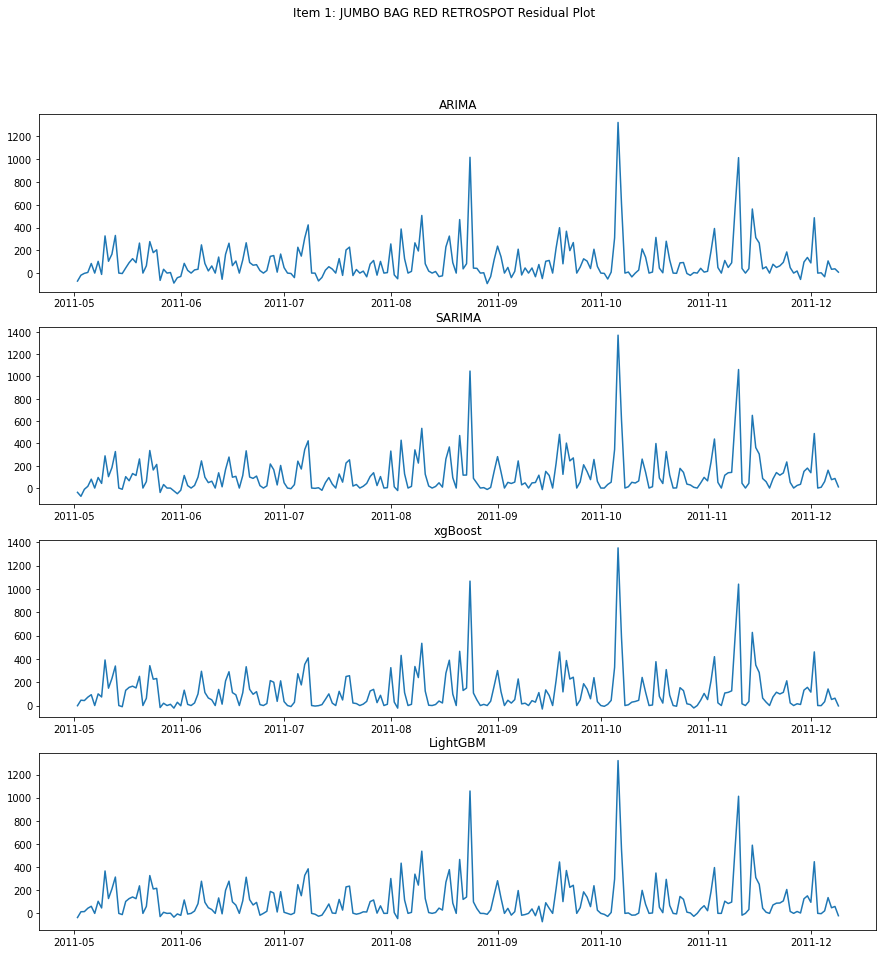

In [215]:
#Plot of residuals for item 1
fig, (ax1,ax2,ax3,ax4)= plt.subplots(4,figsize=(15,15))
fig.suptitle('Item 1: JUMBO BAG RED RETROSPOT Residual Plot')
ax1.plot(np.exp(test.iloc[:,0])- testForecasts['ARIMA Forecast 1 Jumbo'])
ax1.set_title("ARIMA")
ax2.plot(np.exp(test.iloc[:,0])- testForecasts['SARIMA Forecast 1 Jumbo'])
ax2.set_title("SARIMA")
ax3.plot(np.exp(test.iloc[:,0])- testForecasts['xgBoost Forecast 1 Jumbo'])
ax3.set_title("xgBoost")
ax4.plot(np.exp(test.iloc[:,0])- testForecasts['LightGBM Forecast 1 Jumbo'])
ax4.set_title("LightGBM")

Text(0.5, 1.0, 'LightGBM')

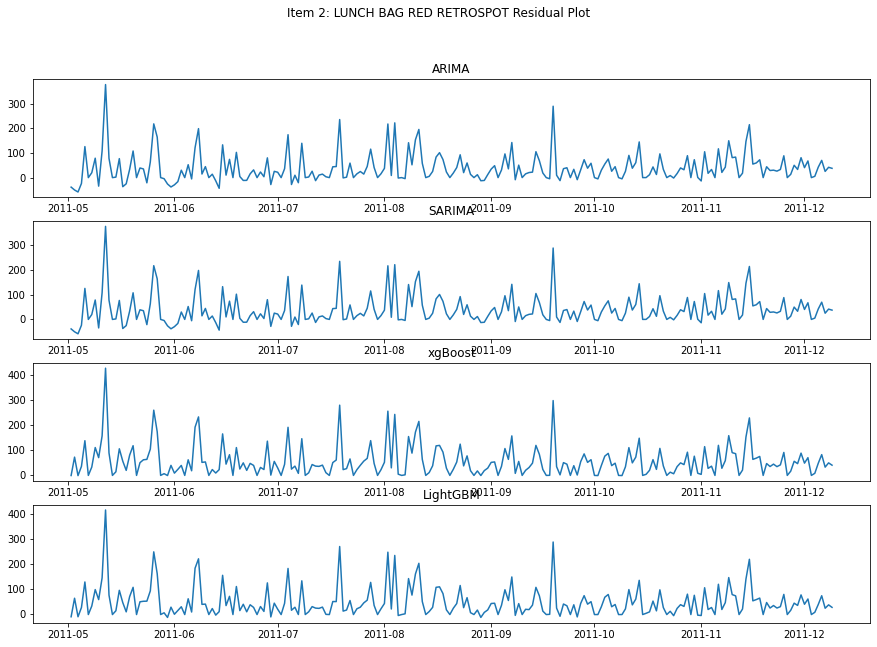

In [112]:
#Plot of the residuals for LUNCH BAG RED RETROSPOT
fig, (ax1,ax2,ax3,ax4)= plt.subplots(4,figsize=(15,10))
fig.suptitle('Item 2: LUNCH BAG RED RETROSPOT Residual Plot')
ax1.plot(np.exp(test.iloc[:,1])- testForecasts['SARIMA Forecast 2 Lunch'])
ax1.set_title("ARIMA")
ax2.plot(np.exp(test.iloc[:,1])- testForecasts['SARIMA Forecast 2 Lunch'])
ax2.set_title("SARIMA")
ax3.plot(np.exp(test.iloc[:,1])- testForecasts['xgBoost Forecast 2 Lunch'])
ax3.set_title("xgBoost")
ax4.plot(np.exp(test.iloc[:,1])- testForecasts['LightGBM Forecast 2 Lunch'])
ax4.set_title("LightGBM")

In [ ]:
#Plot of the residuals for PARTY BUNTING
fig, (ax1,ax2,ax3,ax4)= plt.subplots(4,figsize=(15,10))
fig.suptitle('Item 3: PARTY BUNTING Residual Plot')
ax1.plot(np.exp(test.iloc[:,2])- testForecasts['SARIMA Forecast 4 Regency'])
ax1.set_title("ARIMA")
ax2.plot(np.exp(test.iloc[:,2])- testForecasts['SARIMA Forecast 4 Regency'])
ax2.set_title("SARIMA")
ax3.plot(np.exp(test.iloc[:,2])- testForecasts['xgBoost Forecast 4 Regency'])
ax3.set_title("xgBoost")
ax4.plot(np.exp(test.iloc[:,2])- testForecasts['LightGBM Forecast 4 Regency'])
ax4.set_title("LightGBM")

In [ ]:
#Plot of the residuals for REGENCY CAKESTAND 3 TIER
fig, (ax1,ax2,ax3)= plt.subplots(3,figsize=(15,10))
fig.suptitle('Item 4: REGENCY CAKESTAND 3 TIER Residual Plot')
ax1.plot(np.exp(test.iloc[:,3])- testForecasts['SARIMA Forecast 4 Party'])
ax1.set_title("ARIMA")
ax2.plot(np.exp(test.iloc[:,3])- testForecasts['SARIMA Forecast 4 Party'])
ax2.set_title("SARIMA")
ax3.plot(np.exp(test.iloc[:,3])- testForecasts['xgBoost Forecast 4 Party'])
ax3.set_title("xgBoost")
ax4.plot(np.exp(test.iloc[:,3])- testForecasts['LightGBM Forecast 4 Party'])
ax4.set_title("LightGBM")

Text(0.5, 1.0, 'LightGBM')

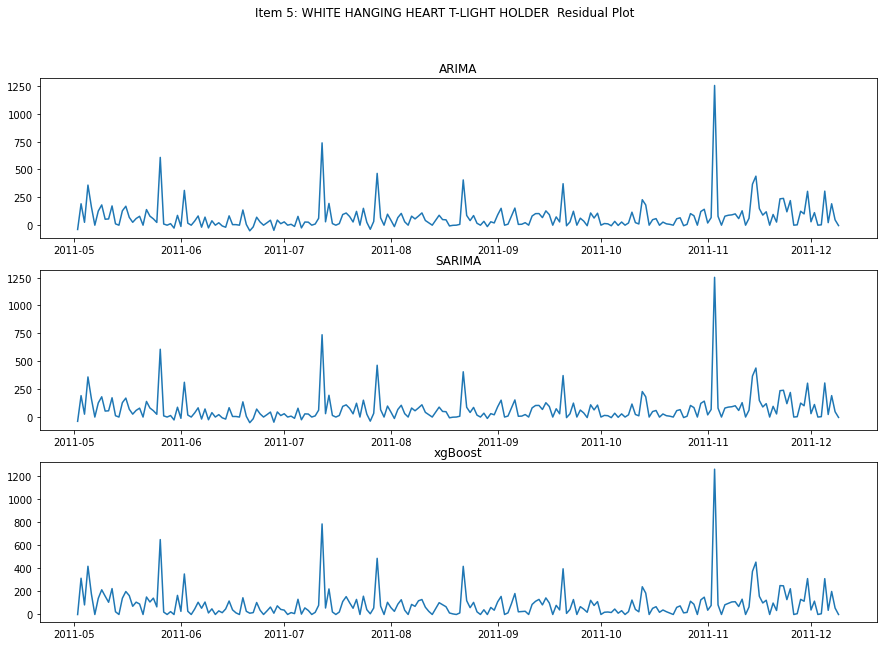

In [113]:
#Plot of the residuals for WHITE HANGING HEART T-LIGHT HOLDER
fig, (ax1,ax2,ax3)= plt.subplots(3,figsize=(15,10))
fig.suptitle('Item 5: WHITE HANGING HEART T-LIGHT HOLDER  Residual Plot')
ax1.plot(np.exp(test.iloc[:,4])- testForecasts['SARIMA Forecast 5 White'])
ax1.set_title("ARIMA")
ax2.plot(np.exp(test.iloc[:,4])- testForecasts['SARIMA Forecast 5 White'])
ax2.set_title("SARIMA")
ax3.plot(np.exp(test.iloc[:,4])- testForecasts['xgBoost Forecast 5 White'])
ax3.set_title("xgBoost")
ax4.plot(np.exp(test.iloc[:,4])- testForecasts['LightGBM Forecast 5 White'])
ax4.set_title("LightGBM")

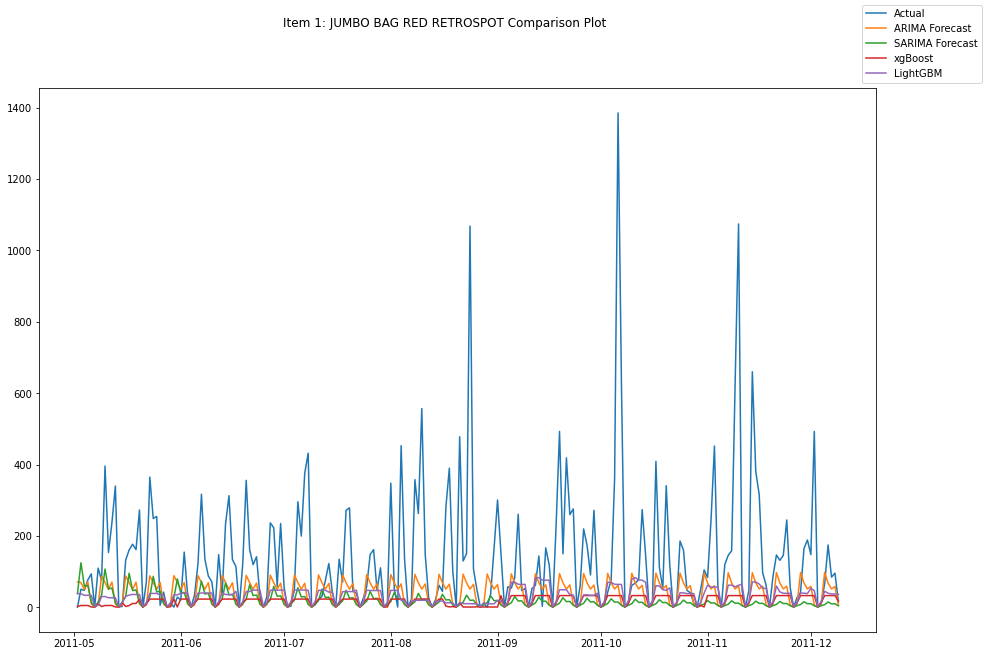

In [117]:
#Graph of predicted valeus vs actual values for Item 1
fig, ax= plt.subplots(figsize=(15,10))
fig.suptitle('Item 1: JUMBO BAG RED RETROSPOT Comparison Plot')
ax.plot(np.exp(test.iloc[:,0]))
ax.plot(testForecasts['ARIMA Forecast 1 Jumbo'])
ax.plot(testForecasts['SARIMA Forecast 1 Jumbo'])
ax.plot(testForecasts['xgBoost Forecast 1 Jumbo'])
ax.plot(testForecasts['LightGBM Forecast 1 Jumbo'])
fig.legend(["Actual", "ARIMA Forecast","SARIMA Forecast","xgBoost","LightGBM"])



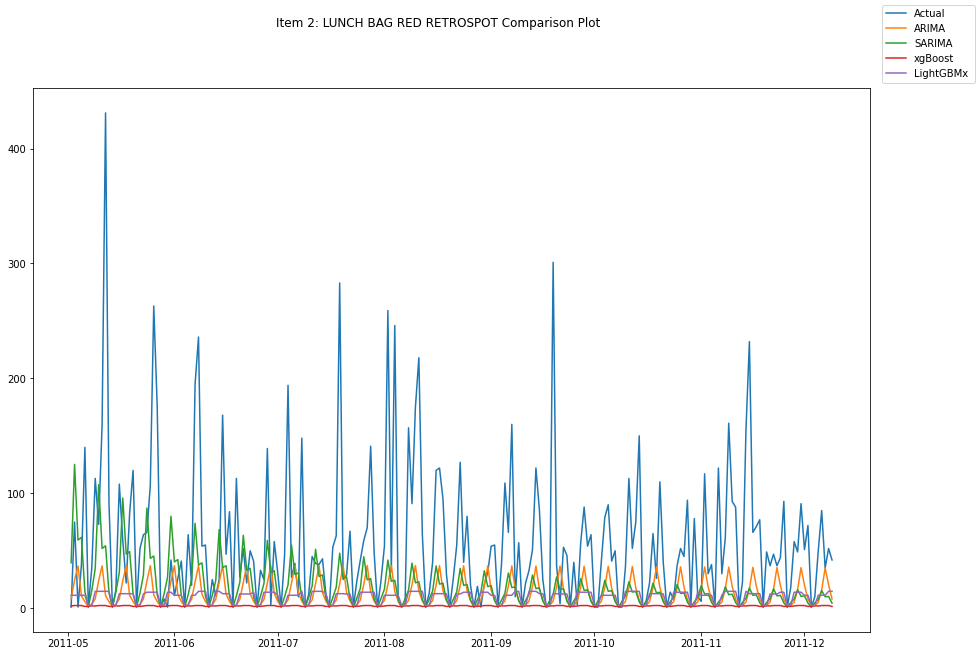

In [124]:
#Graph of predicted valeus vs actual values for Item 2
fig, ax= plt.subplots(figsize=(15,10))
fig.suptitle('Item 2: LUNCH BAG RED RETROSPOT Comparison Plot')
ax.plot(np.exp(test.iloc[:,1]),label = "Actual")
ax.plot(testForecasts['ARIMA Forecast 2 Lunch'],label = "ARIMA")
ax.plot(testForecasts['SARIMA Forecast 2 Lunch'],label = "SARIMA")
ax.plot(testForecasts['xgBoost Forecast 2 Lunch'],label = "xgBoost")
ax.plot(testForecasts['LightGBM Forecast 2 Lunch'],label = "LightGBM")
fig.legend()




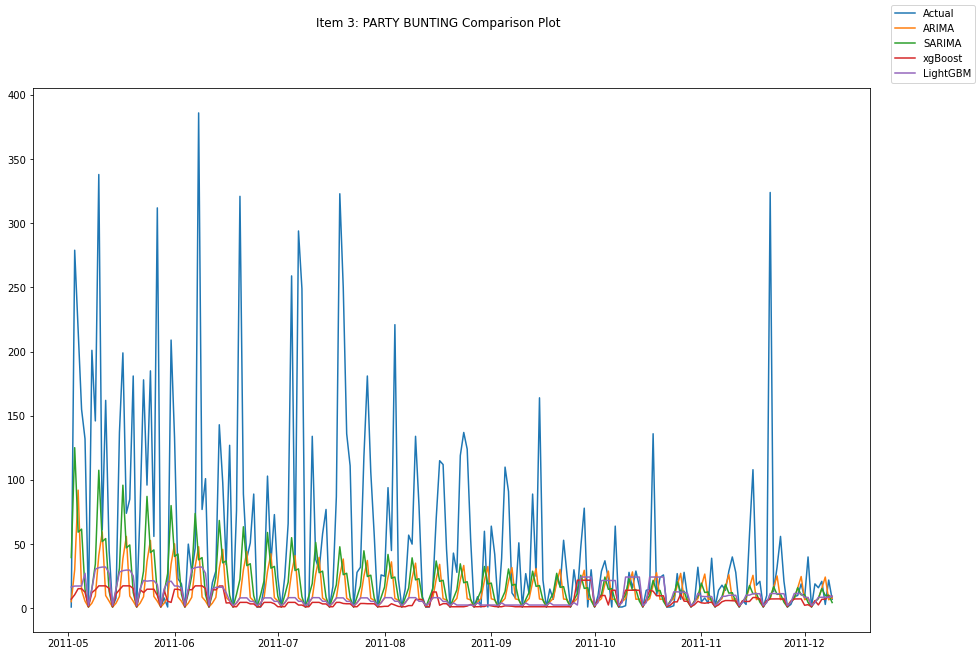

In [126]:
#Graph of predicted valeus vs actual values for Item 3
fig, ax= plt.subplots(figsize=(15,10))
fig.suptitle('Item 3: PARTY BUNTING Comparison Plot')
ax.plot(np.exp(test.iloc[:,2]),label = "Actual")
ax.plot(testForecasts['ARIMA Forecast 3 Party'],label = "ARIMA")
ax.plot(testForecasts['SARIMA Forecast 3 Party'],label = "SARIMA")
ax.plot(testForecasts['xgBoost Forecast 3 Party'],label = "xgBoost")
ax.plot(testForecasts['LightGBM Forecast 3 Party'],label = "LightGBM")
fig.legend()



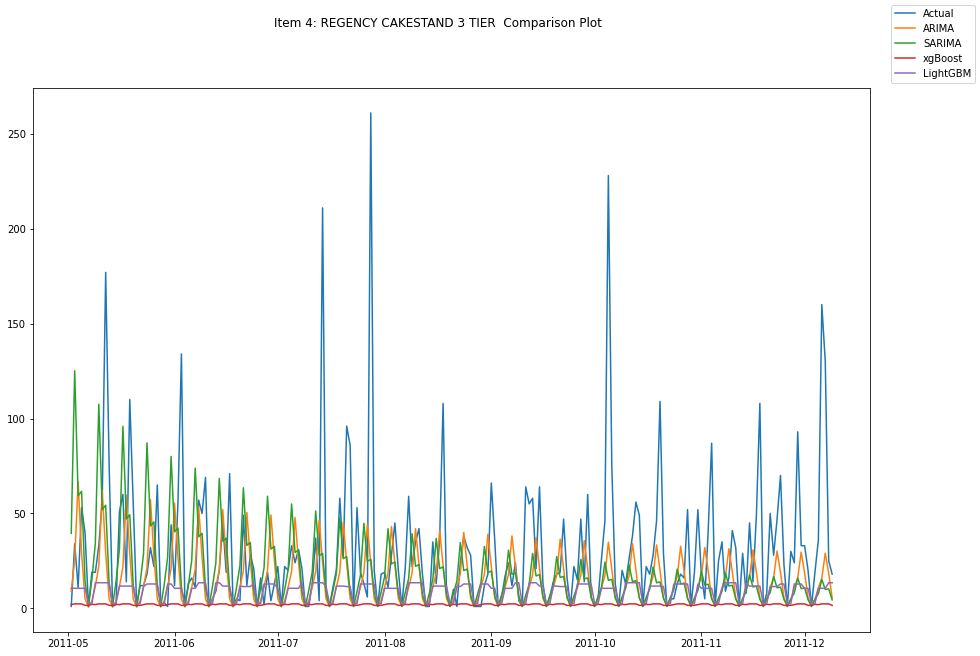

In [127]:
#Graph of predicted valeus vs actual values for Item 4
fig, ax= plt.subplots(figsize=(15,10))
fig.suptitle('Item 4: REGENCY CAKESTAND 3 TIER  Comparison Plot')
ax.plot(np.exp(test.iloc[:,3]),label = "Actual")
ax.plot(testForecasts['ARIMA Forecast 4 Regency'],label = "ARIMA")
ax.plot(testForecasts['SARIMA Forecast 4 Regency'],label = "SARIMA")
ax.plot(testForecasts['xgBoost Forecast 4 Regency'],label = "xgBoost")
ax.plot(testForecasts['LightGBM Forecast 4 Regency'],label = "LightGBM")
fig.legend()



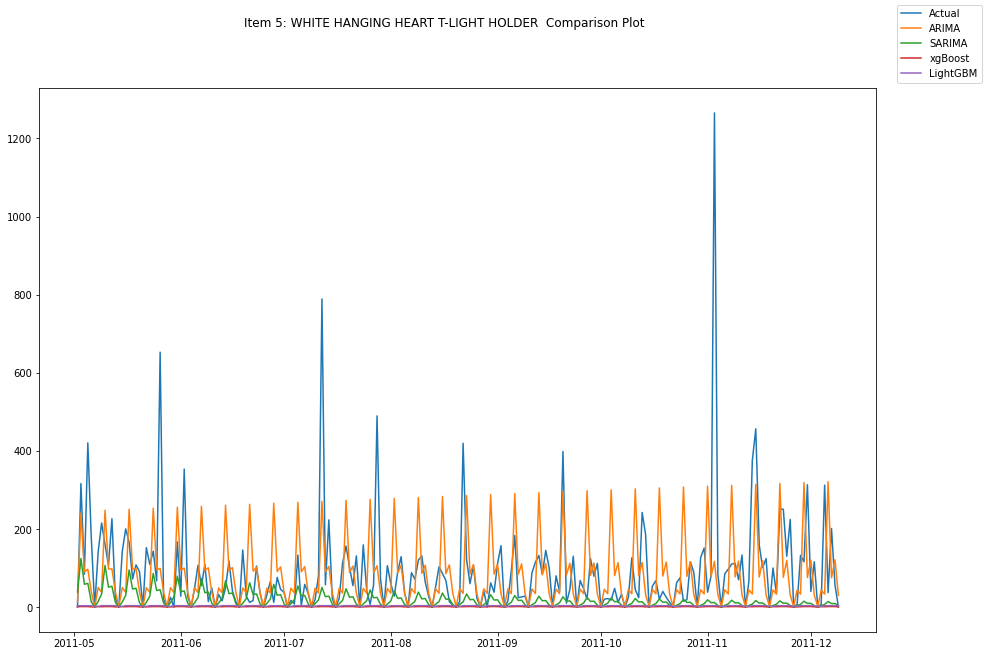

In [128]:
#Graph of predicted valeus vs actual values for Item 5
fig, ax= plt.subplots(figsize=(15,10))
fig.suptitle('Item 5: WHITE HANGING HEART T-LIGHT HOLDER  Comparison Plot')
ax.plot(np.exp(test.iloc[:,4]),label = "Actual")
ax.plot(testForecasts['ARIMA Forecast 5 White'],label = "ARIMA")
ax.plot(testForecasts['SARIMA Forecast 5 White'],label = "SARIMA")
ax.plot(testForecasts['xgBoost Forecast 5 White'],label = "xgBoost")
ax.plot(testForecasts['LightGBM Forecast 5 White'],label = "LightGBM")
fig.legend()


[30.833993747775867, 15.354337952538675, 5.066781248107626, 10.549925945956796]

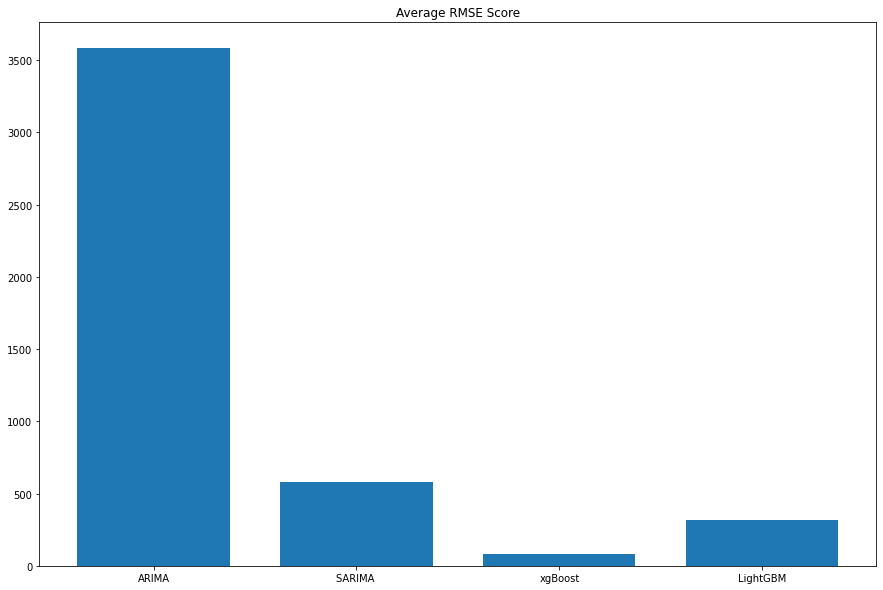

In [216]:
fig, ax = plt.subplots(figsize= (15,10))
arimaRMSEAvg = (arimaModel1RMSE + arimaModel2RMSE + arimaModel3RMSE + arimaModel4RMSE + arimaModel5RMSE)/5
arimaMAEAvg = (arimaModel1MAE + arimaModel2MAE + arimaModel3MAE + arimaModel4MAE + arimaModel5MAE)/5
sarimaRMSEAvg = (sarimaModel1RMSE + sarimaModel2RMSE + sarimaModel3RMSE + sarimaModel4RMSE + sarimaModel5RMSE)/5
sarimaMAEAvg = (sarimaModel1MAE + sarimaModel2MAE + sarimaModel3MAE + sarimaModel4MAE + sarimaModel5MAE)/5
xgboostRMSEAvg = (xgboostModel1RMSE + xgboostModel2RMSE + xgboostModel3RMSE + xgboostModel4RMSE + xgboostModel5RMSE)/5
xgboostMAEAvg = (xgboostModel1MAE + xgboostModel2MAE + xgboostModel3MAE + xgboostModel4MAE + xgboostModel5MAE)/5
lgbRMSEAvg = (lgbModel1RMSE + lgbModel2RMSE +lgbModel3RMSE +lgbModel4RMSE +lgbModel5RMSE)/5
lgbMAEAvg = (lgbModel1MAE + lgbModel2MAE +lgbModel3MAE +lgbModel4MAE +lgbModel5MAE)/5
RMSE = [arimaRMSEAvg, sarimaRMSEAvg, xgboostRMSEAvg, lgbRMSEAvg]
MAE = [arimaMAEAvg, sarimaMAEAvg, xgboostMAEAvg, lgbMAEAvg]
ax.set_title("Average RMSE Score")
ax.bar(np.arange(4),RMSE, width = 0.75)
ax.set_xticks(np.arange(4))
ax.set_xticklabels(["ARIMA","SARIMA ","xgBoost","LightGBM"])


[Text(0, 0, 'ARIMA'),
 Text(1, 0, 'SARIMA '),
 Text(2, 0, 'xgBoost'),
 Text(3, 0, 'LightGBM')]

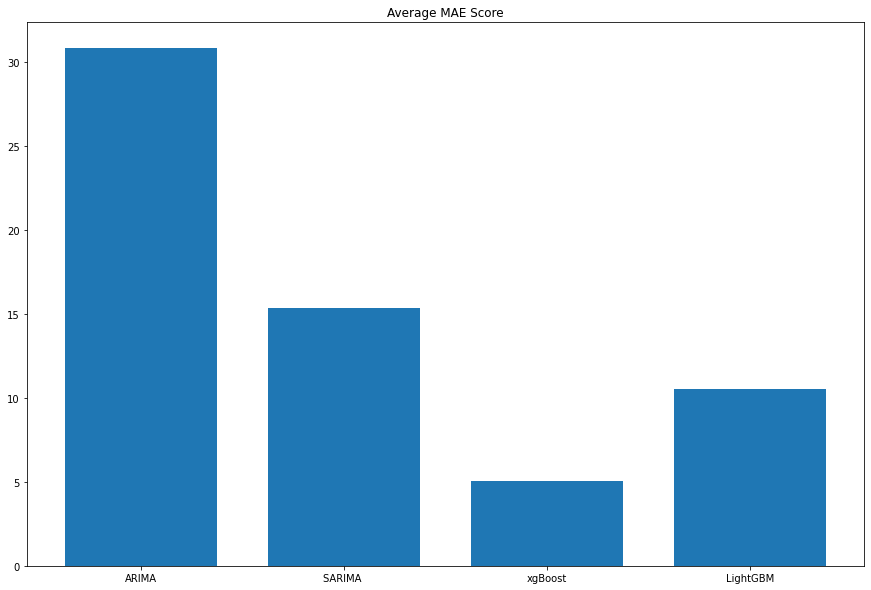

In [214]:
fig, ax = plt.subplots(figsize= (15,10))
ax.set_title("Average MAE Score")
ax.bar(np.arange(4),MAE, width = 0.75)
ax.set_xticks(np.arange(4))
ax.set_xticklabels(["ARIMA","SARIMA ","xgBoost","LightGBM"])

In [218]:
RMSE


[3584.4335357543578, 582.8159440161594, 82.50240319909713, 314.4717984427702]

In [219]:

MAE

[30.833993747775867, 15.354337952538675, 5.066781248107626, 10.549925945956796]

In [220]:
df4.describe()

Description,JUMBO BAG RED RETROSPOT,LUNCH BAG RED RETROSPOT,PARTY BUNTING,REGENCY CAKESTAND 3 TIER,WHITE HANGING HEART T-LIGHT HOLDER
count,739.000000,739.000000,739.000000,739.000000,739.000000
mean,105.669824,30.044655,38.037889,35.353180,125.913396
std,173.857164,54.726241,60.187117,55.081103,194.819291
min,-62.000000,-75.000000,-77.000000,-31.000000,-442.000000
25%,0.000000,0.000000,0.000000,0.000000,23.000000
50%,40.000000,0.000000,14.000000,19.000000,87.000000
75%,147.000000,41.000000,45.000000,49.000000,157.000000
max,1385.000000,548.000000,386.000000,462.000000,3113.000000
